In [1]:
from sklearn.metrics import roc_curve, roc_auc_score
import pandas as pd
import sklearn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay
from sklearn import metrics
import seaborn as sns
from sklearn.metrics import precision_recall_fscore_support

In [ ]:
X, y = dict(), dict()

cleveland_df = pd.read_csv('../data/ProcessedClevelandData.csv')
X['Cleveland'] = cleveland_df.iloc[:,:-1]
y['Cleveland'] = cleveland_df.iloc[:,-1]

hungary_df = pd.read_csv('../data/ProcessedHungaryData.csv')
X['Hungary'] = hungary_df.iloc[:,:-1]
y['Hungary'] = hungary_df.iloc[:,-1]

swiss_df = pd.read_csv('../data/ProcessedSwissData.csv')
X['Switzerland'] = swiss_df.iloc[:,:-1]
y['Switzerland'] = swiss_df.iloc[:,-1]

va_df = pd.read_csv('../data/ProcessedVAData.csv')
X['Long Beach'] = va_df.iloc[:,:-1]
y['Long Beach'] = va_df.iloc[:,-1]

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = dict(), dict(), dict(), dict()

X_train['Cleveland'], X_test['Cleveland'], y_train['Cleveland'], y_test['Cleveland'] = train_test_split(X['Cleveland'], y['Cleveland'], test_size=0.20, random_state=42)

X_train['Hungary'], X_test['Hungary'], y_train['Hungary'], y_test['Hungary'] = train_test_split(X['Hungary'], y['Hungary'], test_size=0.20, random_state=42)

X_train['Switzerland'], X_test['Switzerland'], y_train['Switzerland'], y_test['Switzerland'] = train_test_split(X['Switzerland'], y['Switzerland'], test_size=0.20, random_state=42)

X_train['Long Beach'], X_test['Long Beach'], y_train['Long Beach'], y_test['Long Beach'] = train_test_split(X['Long Beach'], y['Long Beach'], test_size=0.20, random_state=42)

In [23]:
# direct function to train a model on one region and test on another

def learn(region1, region2, model, show_plots=True):

  models = ['RF', 'KNN', 'NB', 'XGB', 'SVM']

  if model == 'RF':
    from sklearn.ensemble import RandomForestClassifier
    clf = RandomForestClassifier(n_estimators = 30,max_depth=2) 

  elif model == 'KNN':
    from sklearn.neighbors import KNeighborsClassifier
    clf = KNeighborsClassifier(n_neighbors = 9)
  
  elif model == 'NB':
    from sklearn.naive_bayes import GaussianNB
    clf = GaussianNB()

  elif model == 'SVM':
    from sklearn.svm import SVC
    clf = SVC(kernel = 'linear',random_state = 0, probability=True)

  elif model == 'XGB':
    import xgboost as xgb
    clf = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
  
  elif model not in models:
    print('Please select a model from list. Refer readme.txt.')

  clf.fit(X_train[region1], y_train[region1])
  y_pred = clf.predict(X_test[region2])

  pr = list(precision_recall_fscore_support(y_test[region2], y_pred, average='macro'))
  pr[3] = clf.score(X_test[region2], y_test[region2])

  if show_plots:
    print('{} on {}->'.format(region1.upper(), region2.upper()))
    print('Model -> {}'.format(model))

    print('| Accuracy | Precision | Recall | Precision |')
    print('| {:.4f} | {:.4f} | {:.4f} |  {:.4f} |'.format(pr[3], pr[0], pr[1], pr[2]))

    plt.ylim(0, 1)
    plt.bar(['Precision','Recall','F1-Score','Accuracy'],pr)
    plt.show()

    print('ROC Curve -> ')
    roc = RocCurveDisplay.from_estimator(clf, X_test[region2], y_test[region2])
    plt.show()

    print('Confusion Matrix -> ')
    confusion_matrix = metrics.confusion_matrix(y_test[region2], y_pred)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])
    cm_display.plot() 
    plt.show()

  return pr[3], pr[0], pr[1]

In [24]:
# function to plot a combined metric bar plot

def bar_plot(acc, pr, re, X, region):
  plt.figure(figsize=(10,6))
  plt.ylim(0, 1)

  X_axis = np.arange(len(X))

  plt.bar(X_axis - 0.2, acc, 0.2, label = 'Accuracy',color='#e76f51')
  plt.bar(X_axis , pr, 0.2, label = 'Precision',color='#2a9d8f')
  plt.bar(X_axis + 0.2, re, 0.2, label = 'Recall',color='#184e77')

  plt.xticks(X_axis, X)
  plt.xlabel("Models")
  plt.title("Performance of model on {} data with other regions".format(region))
  plt.legend()
  plt.show()

In [25]:
# function to plot combined auc curve

def auc(r, model):
  R = ['Cleveland', 'Hungary', 'Switzerland', 'Long Beach']
  if model == 'RF':
    from sklearn.ensemble import RandomForestClassifier
    clf = RandomForestClassifier(n_estimators = 30,max_depth=2) 

  elif model == 'KNN':
    from sklearn.neighbors import KNeighborsClassifier
    clf = KNeighborsClassifier(n_neighbors = 9)
  
  elif model == 'NB':
    from sklearn.naive_bayes import GaussianNB
    clf = GaussianNB()

  elif model == 'SVM':
    from sklearn.svm import SVC
    clf = SVC(kernel = 'linear',random_state = 0, probability=True)

  elif model == 'XGB':
    import xgboost as xgb
    clf = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
  
  else:
    return

  clf.fit(X_train[r], y_train[r])
  plt.figure(figsize=(10,6))
  for z in R:
    y_pred = clf.predict_proba(X_test[z])[:, 1]
    fpr, tpr, thresh = metrics.roc_curve(y_test[z], y_pred)
    auc = metrics.roc_auc_score(y_test[z], y_pred)

    plt.plot(fpr, tpr, label='{}, AUC = {:.3f}'.format(z,auc))

  plt.legend()
  plt.show()

In [19]:
def test_on_rest(region, model):
  acc, pr, re = [0 for x in range(4)], [0 for x in range(4)], [0 for x in range(4)]
  acc[0], pr[0], re[0] = learn(region,'Cleveland',model, False)
  acc[1], pr[1], re[1] = learn(region,'Hungary',model, False)
  acc[2], pr[2], re[2] = learn(region,'Switzerland',model, False)
  acc[3], pr[3], re[3] = learn(region,'Long Beach',model, False)

  X = ['Cleveland', 'Hungary', 'Switzerland', 'Long Beach']

  bar_plot(acc, pr, re, X, region)
  auc(region, model)

In [ ]:
learn('Cleveland','Hungary','RF')

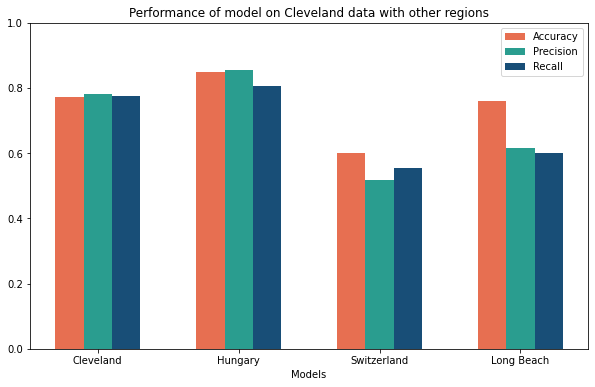

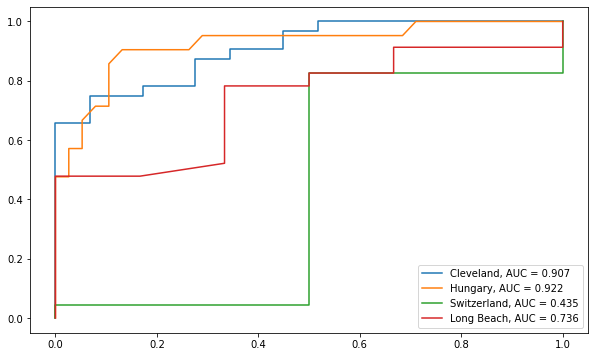

In [20]:
test_on_rest('Cleveland', 'RF')